In [1]:
import numpy as np
import xarray as xr
import glob
from datetime import timedelta

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
outdir='/work/jet/data/interim/'

var = 'psi'
frq = 'annual'
nrho = 'hires'
dset = 'moc_rho2_online_%s'%nrho

In [3]:
ddict = {mod:{} for mod in ['CM4_c192_OM4p25','CM4_c192_OM4p125']}
ddict_exp = {exp:{} for exp in ['piControl_v7','piControl_v8','historical','ssp585']}

for i, mod in enumerate(ddict):
    for j, exp in enumerate(ddict_exp):
        
        if exp.split('_')[0]=='piControl':
            head = 'CM4_%s_c192_%s_%s'%(exp.split('_')[0],mod.split('_')[-1],exp.split('_')[1])
        else:
            head = 'CM4_%s_c192_%s'%(exp,mod.split('_')[-1])
            
        print(head)
        
        files = glob.glob(outdir+head+'_global_*_'+dset+'.nc')
        if len(files)>1:
            print('WARNING: More than one file for '+dset+' in '+head)
        elif len(files)==0:
            print('ERROR: No file available for '+dset+' in '+head)
            ddict_exp[exp] = []
            continue
            
        print('Loading '+files[0])
        da = xr.open_dataset(files[0])[var]
        
        if exp.split('_')[0]=='piControl':
            yr_st_cntr = 101
            yr_st_hist = 1850
            nyrs_shift = yr_st_hist-yr_st_cntr
            print('Shift time axis by',nyrs_shift,'years')
            da['time'] = da.time + timedelta(days=365*nyrs_shift)
        
        ddict_exp[exp] = da

    #print(mod)
    #ddict[mod] = ddict_exp
    ddict[mod] = ddict_exp.copy()

CM4_piControl_c192_OM4p25_v7
Loading /work/jet/data/interim/CM4_piControl_c192_OM4p25_v7_global_0001to0350_moc_rho2_online_hires.nc
Shift time axis by 1749 years
CM4_piControl_c192_OM4p25_v8
Loading /work/jet/data/interim/CM4_piControl_c192_OM4p25_v8_global_0101to0350_moc_rho2_online_hires.nc
Shift time axis by 1749 years
CM4_historical_c192_OM4p25
Loading /work/jet/data/interim/CM4_historical_c192_OM4p25_global_1850to2009_moc_rho2_online_hires.nc
CM4_ssp585_c192_OM4p25
Loading /work/jet/data/interim/CM4_ssp585_c192_OM4p25_global_2010to2099_moc_rho2_online_hires.nc
CM4_piControl_c192_OM4p125_v7
Loading /work/jet/data/interim/CM4_piControl_c192_OM4p125_v7_global_0001to0350_moc_rho2_online_hires.nc
Shift time axis by 1749 years
CM4_piControl_c192_OM4p125_v8
ERROR: No file available for moc_rho2_online_hires in CM4_piControl_c192_OM4p125_v8
CM4_historical_c192_OM4p125
Loading /work/jet/data/interim/CM4_historical_c192_OM4p125_global_1850to1939_moc_rho2_online_hires.nc
CM4_ssp585_c192_OM4p

In [12]:
lstr = [['CM4X-p25 piControl (v7)', 'CM4X-p25 piControl (v8)', 'CM4X-p25 hist', 'CM4X-p25 SSP5-8.5'],
        ['CM4X-p125 piControl (v7)', 'CM4X-p125 piControl (v8)', 'CM4X-p125 hist', 'CM4X-p125 SSP5-8.5']]
lstrc = ['CM4X-p25 hist+SSP5-8.5','CM4X-p125 hist+SSP5-8.5']
cstr = [['g', 'g', 'darkslategrey', 'k'],['b', 'b', 'brown', 'darkred']]
cstrc = ['k','brown']

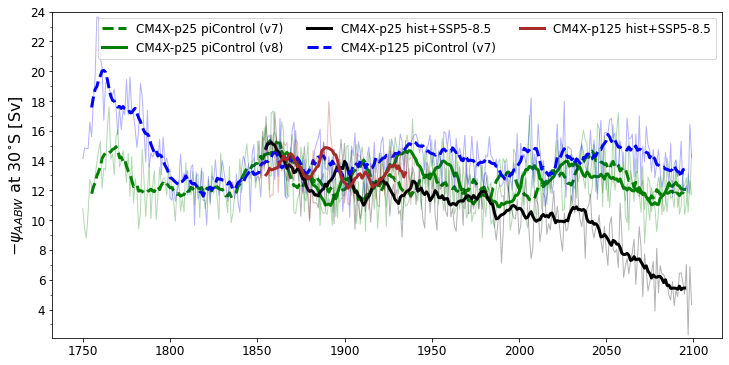

In [12]:
fig, ax = plt.subplots(figsize=(12,6))

for i, mod in enumerate(ddict):
    das = []
    for j, exp in enumerate(ddict[mod]):
        if len(ddict[mod][exp])==0:
            continue
        #print(mod,exp)
        
        da = ddict[mod][exp].sel(rho2_i=slice(1033,1038),yq=slice(None,0))
        da['sigma2'] = da.rho2_i-1000
        da = da.swap_dims({'rho2_i':'sigma2'})
        da_30S = (-da).sel(yq=[-30], method='nearest').squeeze()
        da_30Smax = da_30S.sel(sigma2=slice(36.85,None)).max(dim='sigma2').groupby('time.year').mean('time')
        
        if exp in ['historical','ssp585']:
            das.append(da_30Smax)
            continue
            
        da_30Smax.plot(ax=ax,lw=1,c=cstr[i][j],alpha=0.3,_labels=False)
        da_30Smax.rolling(year=10,center=True).mean().plot(ax=ax,lw=3,c=cstr[i][j],
                                                           ls = '--' if exp.split('_')[-1]=='v7' else '-',
                                                           _labels=False,label=lstr[i][j])
    xr.concat(das, dim='year').plot(ax=ax,lw=1,c=cstrc[i],alpha=0.3,_labels=False)
    xr.concat(das, dim='year').rolling(year=10,center=True).mean().plot(ax=ax,lw=3,c=cstrc[i],
                                                                        ls = '--' if exp.split('_')[-1]=='v7' else '-',
                                                                        _labels=False,label=lstrc[i])
    
        
ax.set_ylim([2.1, 24])
ax.set_yticks(np.arange(4,26,2))
ax.set_yticks(np.arange(3,24,1),minor=True)
ax.legend(frameon=True, fancybox=True, loc='upper right', ncol=3, fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel('$-\psi_{AABW}$ at 30$^{\circ}$S [Sv]', fontsize=16)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Version for manuscript 

In [18]:
tsdict = {mod:{} for mod in list(ddict.keys())}

for i, mod in enumerate(ddict):
    das = []
    for j, exp in enumerate(ddict[mod]):
        if len(ddict[mod][exp])==0:
            tsdict[mod][exp] = []
            continue
        print(mod,exp)
        
        da = ddict[mod][exp].sel(rho2_i=slice(1033,1038),yq=slice(None,0))
        da['sigma2'] = da.rho2_i-1000
        da = da.swap_dims({'rho2_i':'sigma2'})
        da_30S = (-da).sel(yq=[-30], method='nearest').squeeze()
        da_30Smax = da_30S.sel(sigma2=slice(36.85,None)).max(dim='sigma2').groupby('time.year').mean('time')
        
        tsdict[mod][exp] = da_30Smax

CM4_c192_OM4p25 piControl_v7
CM4_c192_OM4p25 piControl_v8
CM4_c192_OM4p25 historical
CM4_c192_OM4p25 ssp585
CM4_c192_OM4p125 piControl_v7
CM4_c192_OM4p125 historical


In [24]:
psi_p25_piControl = xr.concat([tsdict['CM4_c192_OM4p25']['piControl_v7'].sel(year=slice(None, 1849)),tsdict['CM4_c192_OM4p25']['piControl_v8']], dim='year')
psi_p25_hist_ssp = xr.concat([tsdict['CM4_c192_OM4p25']['historical'],tsdict['CM4_c192_OM4p25']['ssp585']], dim='year')
psi_p125_piControl = tsdict['CM4_c192_OM4p125']['piControl_v7']
psi_p125_hist_ssp = tsdict['CM4_c192_OM4p125']['historical']

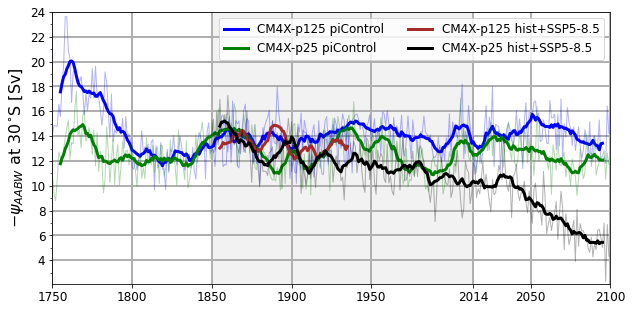

In [33]:
fig, ax = plt.subplots(figsize=(10,5))

psi_p125_piControl.plot(ax=ax,lw=1,c='b',alpha=0.3,_labels=False)
psi_p125_piControl.rolling(year=10,center=True).mean().plot(ax=ax,lw=3,c='b',ls = '-',_labels=False,label='CM4X-p125 piControl')

psi_p25_piControl.plot(ax=ax,lw=1,c='g',alpha=0.3,_labels=False)
psi_p25_piControl.rolling(year=10,center=True).mean().plot(ax=ax,lw=3,c='g',ls = '-',_labels=False,label='CM4X-p25 piControl')

psi_p125_hist_ssp.plot(ax=ax,lw=1,c='b',alpha=0.3,_labels=False)
psi_p125_hist_ssp.rolling(year=10,center=True).mean().plot(ax=ax,lw=3,c='brown',ls = '-',_labels=False,label='CM4X-p125 hist+SSP5-8.5')

psi_p25_hist_ssp.plot(ax=ax,lw=1,c='k',alpha=0.3,_labels=False)
psi_p25_hist_ssp.rolling(year=10,center=True).mean().plot(ax=ax,lw=3,c='k',ls = '-',_labels=False,label='CM4X-p25 hist+SSP5-8.5')

    
ax.set_ylim([2.1, 24])
ax.set_yticks(np.arange(4,26,2))
ax.set_yticks(np.arange(3,24,1),minor=True)

ax.set_xlim(1750,2100)
ax.set_xticks(ticks=[1750, 1800, 1850, 1900, 1950, 2014, 2050, 2100])
ax.set_ylabel('$-\psi_{AABW}$ at 30$^{\circ}$S [Sv]', fontsize=16)
#ax.set_xlabel('year')
ax.grid(linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(frameon=True, fancybox=True, loc='upper right', ncol=2, fontsize=12)

ylimit = ax.get_ylim()
ax.fill([1850,2014,2014,1850],[ylimit[0]-1,ylimit[0]-1,ylimit[1]+0.2,ylimit[1]+0.2],'grey', alpha=0.1, edgecolor='None')

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()